In [1]:
### Setup Environment ###
import numpy as np
import pandas as pd
import plotly_express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import chi2_contingency
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from itertools import combinations

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.4f}'.format})
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('matchups_portal.csv')
df = df[df['round'] == 'First Round']
print(df.shape)
df.head()

(127, 87)


,year,region,round,high_bracket_seed,high_bracket_team,low_bracket_seed,low_bracket_team,win,wab,prpg!,...,D_B,D_C,D_D,D_F,F_S,F_A,F_B,F_C,F_D,F_F
0,2021,West,First Round,1,2021 Gonzaga,16,2021 Norfolk St.,1,13.5317,12.7000,...,0,0,0,0,0,0,0,0,0,0
6,2021,East,First Round,6,2021 BYU,11,2021 UCLA,0,0.9115,-3.8000,...,0,0,0,0,0,0,0,0,0,0
8,2021,West,First Round,8,2021 Oklahoma,9,2021 Missouri,1,-1.7879,-2.6000,...,0,0,0,0,0,0,0,0,0,0
9,2021,West,First Round,5,2021 Creighton,12,2021 UC Santa Barbara,1,3.1257,1.8000,...,0,0,0,0,0,0,0,0,0,0
11,2021,West,First Round,4,2021 Virginia,13,2021 Ohio,0,5.5191,3.3000,...,0,0,0,0,0,0,0,0,0,0


In [2]:
df['win'].value_counts(normalize=True)

1   0.6929
0   0.3071
Name: win, dtype: float64

In [3]:
df.columns

Index(['year', 'region', 'round', 'high_bracket_seed', 'high_bracket_team',
       'low_bracket_seed', 'low_bracket_team', 'win', 'wab', 'prpg!', 'dprpg',
       'bpm', 'obpm', 'dbpm', 'bpr', 'obpr', 'dbpr', 'kenpom_adjem',
       'kenpom_adjoe', 'kenpom_adjde', 'barthag', 'barthag_oe', 'barthag_de',
       'off_eff', 'def_eff', 'efg%', 'ftr', 'tor', 'orb%', 'efgd%', 'ftrd',
       'tord', 'drb%', '2p%', '3p%', 'blked%', 'ast%', '3pr', 'ft%', '2p%d',
       '3p%d', 'blk%', 'ast%d', '3prd', 'ft%d', 'height', 'size', 'experience',
       'bench', 'high_tier', 'low_tier', 'S_S', 'S_A', 'S_B', 'S_C', 'S_D',
       'S_F', 'A_S', 'A_A', 'A_B', 'A_C', 'A_D', 'A_F', 'B_S', 'B_A', 'B_B',
       'B_C', 'B_D', 'B_F', 'C_S', 'C_A', 'C_B', 'C_C', 'C_D', 'C_F', 'D_S',
       'D_A', 'D_B', 'D_C', 'D_D', 'D_F', 'F_S', 'F_A', 'F_B', 'F_C', 'F_D',
       'F_F'],
      dtype='object')

In [4]:
eda_df = df[[
    'win', 
    'wab', 
    'prpg!', 
    'dprpg',
    'bpm', 
    'obpm', 
    'dbpm', 
    'kenpom_adjem',
    'kenpom_adjoe', 
    'kenpom_adjde', 
    'barthag', 
    'barthag_oe', 
    'barthag_de',
    'off_eff', 
    'def_eff', 
    'efg%',
    'ftr', 
    'tor', 
    'orb%', 
    'efgd%', 
    'ftrd',
    'tord', 
    'drb%', 
    '2p%', 
    '3p%', 
    'blked%', 
    'ast%', 
    '3pr', 
    'ft%', 
    '2p%d',
    '3p%d', 
    'blk%', 
    'ast%d', 
    '3prd', 
    'ft%d', 
    'height', 
    'size', 
    'experience',
    'bench']]

In [5]:
# Split dataset into a train and test set
X = eda_df.iloc[:,1:]
Y = eda_df['win']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(train_df.shape)
print(test_df.shape)

(88, 39)
(39, 39)


# I. Numerical Tests

In [27]:
corr_matrix = train_df.corr()
correlation_with_target = round(abs(corr_matrix['win'])*100,2)
correlation_with_target = correlation_with_target[correlation_with_target >= 20]
print(correlation_with_target)

wab             27.2200
prpg!           35.8300
dprpg           29.1900
bpm             35.1300
obpm            39.9100
dbpm            24.0000
kenpom_adjem    29.4800
kenpom_adjoe    28.8900
barthag         31.0200
barthag_oe      28.5600
bench           25.1200
win            100.0000
Name: win, dtype: float64


In [28]:
X = train_df.drop('win', axis=1)
y = train_df['win']

# ANOVA
f_values, p_values = f_classif(X, y)
# Mutual Information
mi = mutual_info_regression(X, y)

column_names = np.array(X.columns)
stats_df = pd.DataFrame({
    'feature': column_names,
    'f_values': f_values,
    'p_values': p_values,
    'mutual_info': mi
})
stats_df

,feature,f_values,p_values,mutual_info
0,wab,6.8834,0.0103,0.0837
1,prpg!,12.6687,0.0006,0.0071
2,dprpg,8.0120,0.0058,0.0022
3,bpm,12.1097,0.0008,0.0021
4,obpm,16.2964,0.0001,0.0955
5,dbpm,5.2577,0.0243,0.0000
6,kenpom_adjem,8.1874,0.0053,0.0607
7,kenpom_adjoe,7.8335,0.0063,0.0151
8,kenpom_adjde,1.0281,0.3134,0.1045
9,barthag,9.1552,0.0033,0.0023


In [29]:
stats_df[stats_df['mutual_info'] > .05]

,feature,f_values,p_values,mutual_info
0,wab,6.8834,0.0103,0.0837
4,obpm,16.2964,0.0001,0.0955
6,kenpom_adjem,8.1874,0.0053,0.0607
8,kenpom_adjde,1.0281,0.3134,0.1045
10,barthag_oe,7.6350,0.0070,0.0605
11,barthag_de,2.4089,0.1243,0.0568
18,efgd%,0.0307,0.8613,0.0971
22,2p%,2.3466,0.1292,0.0976
26,3pr,0.8899,0.3481,0.0519
31,ast%d,1.0332,0.3123,0.0937


In [30]:
stats_df[stats_df['p_values'] < .05]

,feature,f_values,p_values,mutual_info
0,wab,6.8834,0.0103,0.0837
1,prpg!,12.6687,0.0006,0.0071
2,dprpg,8.0120,0.0058,0.0022
3,bpm,12.1097,0.0008,0.0021
4,obpm,16.2964,0.0001,0.0955
5,dbpm,5.2577,0.0243,0.0000
6,kenpom_adjem,8.1874,0.0053,0.0607
7,kenpom_adjoe,7.8335,0.0063,0.0151
9,barthag,9.1552,0.0033,0.0023
10,barthag_oe,7.6350,0.0070,0.0605


In [31]:
stats_df[stats_df['f_values'] > 5]

,feature,f_values,p_values,mutual_info
0,wab,6.8834,0.0103,0.0837
1,prpg!,12.6687,0.0006,0.0071
2,dprpg,8.0120,0.0058,0.0022
3,bpm,12.1097,0.0008,0.0021
4,obpm,16.2964,0.0001,0.0955
5,dbpm,5.2577,0.0243,0.0000
6,kenpom_adjem,8.1874,0.0053,0.0607
7,kenpom_adjoe,7.8335,0.0063,0.0151
9,barthag,9.1552,0.0033,0.0023
10,barthag_oe,7.6350,0.0070,0.0605


# II. Wrapper Methods

In [32]:
X_train = train_df.drop('win', axis=1)
y_train = train_df['win']

X_test = test_df.drop('win', axis=1)
y_test = test_df['win']

float64_columns = X_train.select_dtypes(include=['float64']).columns

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[float64_columns] = scaler.fit_transform(X_train[float64_columns])

X_test_scaled = X_test.copy()
X_test_scaled[float64_columns] = scaler.transform(X_test[float64_columns])

In [33]:
sel_ = SelectFromModel(
    LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

sel_.fit(X_train_scaled, y_train)

SelectFromModel(estimator=LogisticRegression(C=0.5, penalty='l1',
                                             random_state=10,
                                             solver='liblinear'))

In [34]:
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 38
selected features: 15
features with coefficients shrank to zero: 23


In [35]:
selected_feat

Index(['dprpg', 'obpm', 'off_eff', 'def_eff', 'tor', 'orb%', 'ftrd', 'drb%',
       'ft%', '2p%d', 'blk%', 'ast%d', '3prd', 'height', 'experience'],
      dtype='object')

In [36]:
# Transform datasets based on selected features
X_train_selected = sel_.transform(X_train_scaled)
X_test_selected = sel_.transform(X_test_scaled)

# Train a Lasso regression model
lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(X_train_selected, y_train)

# Make predictions
y_train_pred = lasso.predict(X_train_selected)
y_test_pred = lasso.predict(X_test_selected)

# Convert predictions to binary using a threshold
threshold = 0.5
y_train_pred_binary = (y_train_pred >= threshold).astype(int)
y_test_pred_binary = (y_test_pred >= threshold).astype(int)

# Evaluate F1 scores
f1_train = f1_score(y_train, y_train_pred_binary)
f1_test = f1_score(y_test, y_test_pred_binary)

print(f"Lasso Regression F1 Score (Train): {f1_train:.2f}")
print(f"Lasso Regression F1 Score (Test): {f1_test:.2f}")

Lasso Regression F1 Score (Train): 0.83
Lasso Regression F1 Score (Test): 0.84


In [37]:
sfs = SequentialFeatureSelector(
        estimator=RandomForestClassifier(
        n_estimators=10, n_jobs=4, random_state=0),
        n_features_to_select=10,  # the number of features to retain
        direction='backward',  # the direction of the selection procedure
        scoring='roc_auc',  # the metric to evaluate
        cv=2, # the cross-validation fold
        n_jobs=None
)


sfs = sfs.fit(X_train, y_train)

In [38]:
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=3)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [39]:
selected_feat= sfs.get_feature_names_out()
selected_feat

array(['obpm', 'barthag_oe', 'def_eff', 'tor', 'drb%', '2p%', 'ast%',
       'ft%', 'ast%d', 'ft%d'], dtype=object)

In [40]:
run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9924021040327294
Test set
Random Forests roc-auc: 0.45517241379310347


In [41]:
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9988310929281122
Test set
Random Forests roc-auc: 0.5758620689655173


In [42]:
roc_values = []

# iterate over each feature in the dataset
for feature in X_train.columns:

    # train a decision tree classifier
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)

    # obtain the predictions
    y_scored = clf.predict_proba(X_test[feature].to_frame())

    # calculate and store the roc-auc
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
# display the result
roc_values

[0.5948275862068966,
 0.43448275862068964,
 0.6637931034482758,
 0.5344827586206897,
 0.47758620689655173,
 0.5982758620689655,
 0.6448275862068966,
 0.3448275862068966,
 0.6448275862068966,
 0.45862068965517244,
 0.46206896551724136,
 0.42931034482758623,
 0.5275862068965517,
 0.7620689655172415,
 0.3793103448275862,
 0.3603448275862069,
 0.693103448275862,
 0.5172413793103449,
 0.4172413793103448,
 0.44482758620689655,
 0.3810344827586207,
 0.5879310344827586,
 0.40689655172413797,
 0.4206896551724138,
 0.39137931034482765,
 0.5362068965517242,
 0.3620689655172414,
 0.5103448275862069,
 0.5103448275862069,
 0.546551724137931,
 0.45862068965517244,
 0.6017241379310345,
 0.5655172413793104,
 0.3379310344827586,
 0.39137931034482765,
 0.36724137931034484,
 0.4603448275862069,
 0.4948275862068966]

Text(0, 0.5, 'roc-auc')

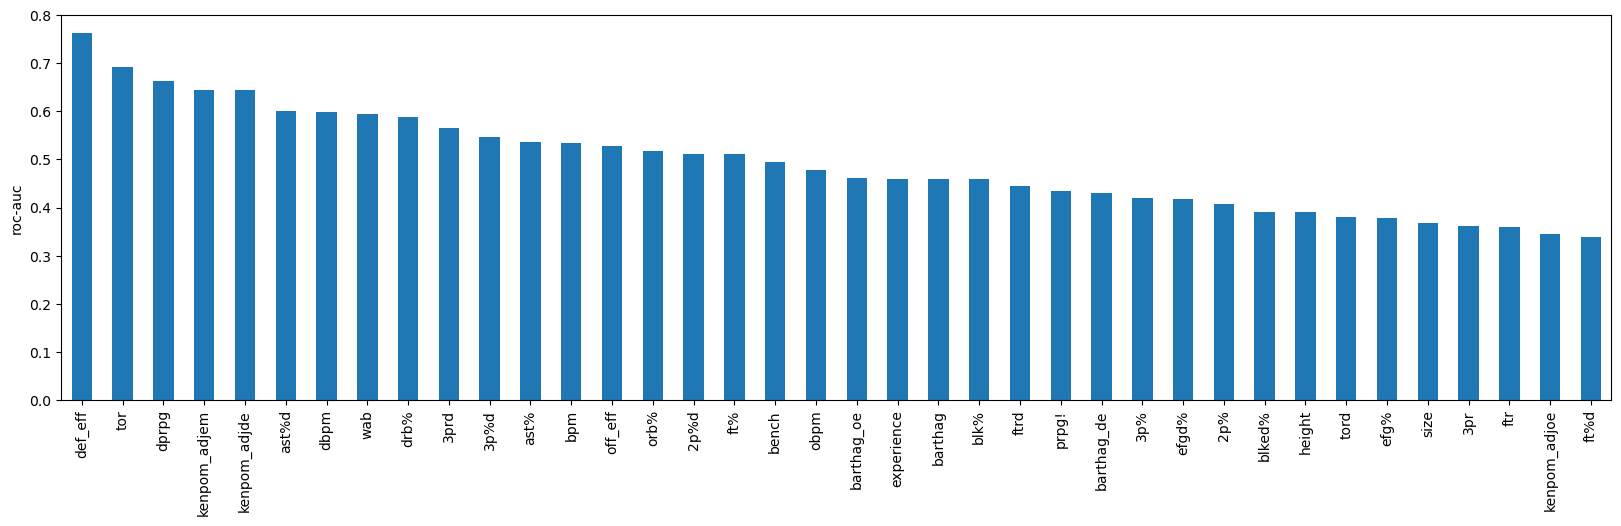

In [43]:
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 5))
plt.ylabel('roc-auc')

In [44]:
len(roc_values[roc_values > 0.6])

6

In [45]:
roc_values[roc_values > 0.6]

dprpg          0.6638
kenpom_adjem   0.6448
kenpom_adjde   0.6448
def_eff        0.7621
tor            0.6931
ast%d          0.6017
dtype: float64

In [46]:
roc_values[roc_values > 0.55]

wab            0.5948
dprpg          0.6638
dbpm           0.5983
kenpom_adjem   0.6448
kenpom_adjde   0.6448
def_eff        0.7621
tor            0.6931
drb%           0.5879
ast%d          0.6017
3prd           0.5655
dtype: float64

# III. XGBoost

In [59]:
X_train_scaled2 = X_train_scaled[[
 'wab',
 'dprpg',
 'kenpom_adjem',
 'def_eff',
 'tor',
 'drb%',
 'ast%d',
 '3prd'
]]

X_test_scaled2 = X_test_scaled[[
 'wab',
 'dprpg',
 'kenpom_adjem',
 'def_eff',
 'tor',
 'drb%',
 'ast%d',
 '3prd'
]]

In [60]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Set up hyperparameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300, 400, 500, 1000],
    'subsample': [0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6],
    'gamma': [0.2, 0.3, 0.4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_log_loss', cv=5, verbose=1, n_jobs=-1)

# Fit grid search
grid_search.fit(X_train_scaled2, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
Best Hyperparameters: {'colsample_bytree': 0.5, 'gamma': 0.3, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.4}


In [61]:
# Retrain the model with the best parameters
best_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    **best_params
)

best_xgb_model.fit(X_train_scaled2, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [62]:
# Predict probabilities
y_pred_proba = best_xgb_model.predict_proba(X_test_scaled2)[:, 1]

# Calculate Log Loss
logloss = log_loss(y_test, y_pred_proba)
print(f"Log Loss on test set: {logloss}")

Log Loss on test set: 0.5595665212831781


In [63]:
# Predictions
y_train_pred = best_xgb_model.predict(X_train_scaled2)
y_test_pred = best_xgb_model.predict(X_test_scaled2)

# Calculate accuracy scores
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print(f"F1 Score on Training Data: {f1_train:.2f}")
print(f"F1 Score on Test Data: {f1_test:.2f}")

F1 Score on Training Data: 0.86
F1 Score on Test Data: 0.86


<Figure size 1000x600 with 0 Axes>

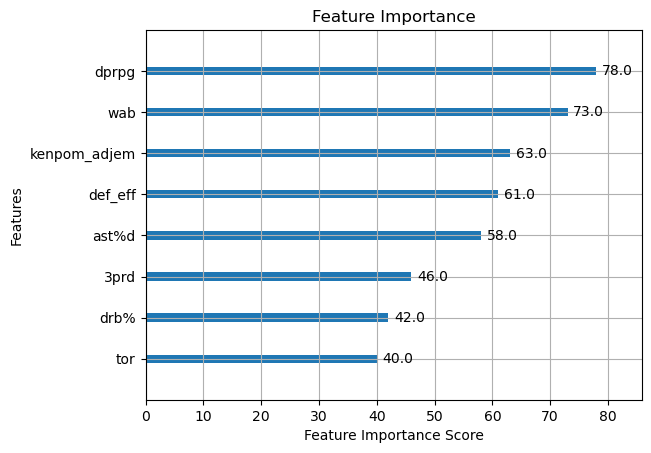

In [64]:
from xgboost import plot_importance

# Extract feature importance
feature_importance = best_xgb_model.get_booster().get_score(importance_type='weight')

# Visualize feature importance
plt.figure(figsize=(10, 6))
plot_importance(best_xgb_model, importance_type='weight', show_values=True, xlabel='Feature Importance Score')
plt.title('Feature Importance')
plt.show()